Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile("m4.1s.jls") && include("m4.1s.jl")

chn = deserialize("m4.1s.jls")

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[7.49528 154.421; 8.49254 154.732; … ; 7.93427 154.497; 7.61197 154.754]

Union{Missing, Float64}[8.00183 155.376; 7.93779 154.841; … ; 7.72013 154.302; 7.83565 154.101]

Union{Missing, Float64}[7.70308 155.125; 7.77408 154.533; … ; 7.95918 153.977; 7.32339 154.325]

Union{Missing, Float64}[7.6667 154.218; 7.22155 154.841; … ; 7.70084 154.958; 7.91763 154.184]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
          Mean        SD      Naive SE      MCSE     ESS
sigma   7.7697297 0.2914439 0.004608133 0.004863396 1000
   mu 154.6100125 0.4086380 0.006461134 0.005716484 1000

Quantiles:
         2.5%       25.0%      50.0%     75.0%       97.5%  
sigma   7.218333   7.5693325   7.7624   7.9619275   8.373182
   mu 153.786925 154.3350000 154.6145 154.8850000 155.394000



Plot the density of posterior draws

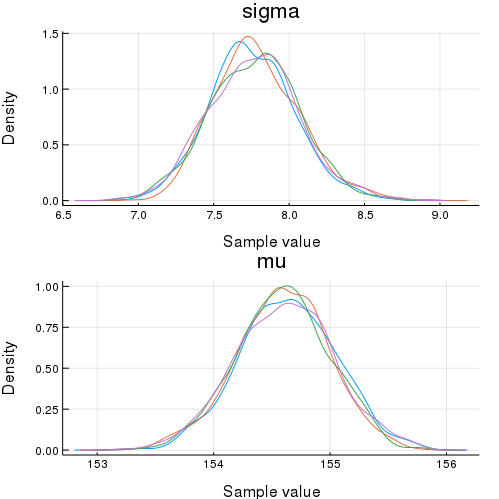

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.1700060509699699 
 0.07982000654339298

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
  1.0          -0.000245061
 -0.000245061   1.0        

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*